In [178]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from tkinter import Tk     


# Data selection
choose which data are used in the experiment, english and thai one

In [254]:
# read and claen the data file from task III (image word relationship test)
# let the user choose the file
 
from tkinter.filedialog import askopenfilename

Tk().withdraw() # we don't want a full GUI, so keep the root window from appearing

username = input("user identity (this string will be named in front of every graph picture):")
datafile = askopenfilename(title="Choose the data file from the experiment, TH mode")
imgordth = pd.read_csv(datafile)
datafile = askopenfilename(title="Choose the data file from the experiment, EN mode")
imgorden = pd.read_csv(datafile)


# cleaning data
this but a simple row removal and column renaming for convenience

In [255]:
# claenadata
def III_cut_and_clean(prepdf):
    cutdf = prepdf.iloc[1:241][["lang","wordid","truestate","image.started","key_resp.started","key_resp.keys","key_resp.rt"]].reset_index(drop=True)
    cutdf = cutdf.rename({"image.started":"word_show","key_resp.started":"image_show","key_resp.keys":"key","key_resp.rt":"key_RT"}, axis="columns")
    return cutdf

imgordth = III_cut_and_clean(imgordth)
imgorden = III_cut_and_clean(imgorden)

# call the reference table
oldword = pd.read_excel("./image test/ref/wordlist_dict.xlsx")
newword = pd.read_excel("./image test/ref/newwordlist_dict.xlsx")


# Define function that add that word is shown and whether if its an old or new image
add column `word shown` for easier datafram reading, `old-new` for a new and old word, and `len` for word length

In [256]:
# add word that actually show and add is it an old or new word
# also add length of that word

# but need to read the file language first
def III_wordload_len_learnt(cutdf):
    if cutdf.iloc[0,0] == 1:
        print("thai language experiemnt loaded")
        globallang = 'th'

    elif cutdf.iloc[0,0] == 2:
        print("english language experiemnt loaded")
        globallang = 'en'

    else:
        print("??????????????????? what file did you choose dawg?")

    for i in range(0,len(cutdf.index)):
        idnow = cutdf.loc[i,"wordid"]
        if idnow in oldword['imgid'].values :
            wordshown = oldword.loc[(oldword['imgid'] == idnow), [globallang]].values[0]
            cutdf.loc[i,"word shown"] = wordshown
            cutdf.loc[i,"old-new"] = "old"

        elif idnow in newword['imgid'].values:
            wordshown = newword.loc[(newword['imgid'] == idnow), [globallang]].values[0]
            cutdf.loc[i,"word shown"] = wordshown
            cutdf.loc[i,"old-new"] = "new"
        else:
            print("unkown id used in the experiment file, stopping loop")
            break

        cutdf.loc[i, "len"] = len(wordshown[0])


In [257]:
III_wordload_len_learnt(imgorden)
III_wordload_len_learnt(imgordth)

english language experiemnt loaded
thai language experiemnt loaded


In [258]:
# special, remove the word that user is not understandf before
def III_remove_excluded_words(df, exclude_words):
    # Ensure 'word shown' is a string column, and then strip and convert to lowercase
    df['word shown'] = df['word shown'].astype(str).str.strip().str.lower()

    # Convert the exclude_words list to lowercase for case-insensitivity
    # exclude_words = [word.lower() for word in exclude_words]

    # Filter out rows where 'word shown' contains any of the words in exclude_words
    df_filtered = df[~df['word shown'].isin(exclude_words)]
    
    print(f"Rows removed: {len(df) - len(df_filtered)}")  # Print how many rows were removed
    return df_filtered

In [259]:
exclude_words =  ["pear", "hose", "drill", "couch"]
imgorden = III_remove_excluded_words(imgorden, exclude_words)

Rows removed: 16


# Assign score 

In [260]:
# read the key and truestate file --> assign scoer --> plot total score in each correct and incorrect
def III_total_score(cutdf, titlelang, dir):
    cutdf.loc[(cutdf["truestate"] == 0) & (cutdf["key"] == 'z'),"score"] = 0
    cutdf.loc[(cutdf["truestate"] == 0) & (cutdf["key"] == 'x'),"score"] = 1
    cutdf.loc[(cutdf["truestate"] == 1) & (cutdf["key"] == 'z'),"score"] = 1
    cutdf.loc[(cutdf["truestate"] == 1) & (cutdf["key"] == 'x'),"score"] = 0

    correctscore = cutdf.loc[cutdf['score'] == 1, "score"].count()
    wrongscore = cutdf.loc[cutdf['score'] == 0,"score"].count()
    total = correctscore + wrongscore

    # xlabelstr = f"{100*correctscore / total:.2f}%({correctscore}) correct, {100*wrongscore / total:.2f}%({wrongscore}) wrong, {total} total"
    
    # plt.figure(figsize=(6, 5))
    # plt.bar(["correct", "incorrect"],[correctscore, wrongscore], width=0.5, edgecolor='black')
    # plt.title(f"correct and incorrect ratio, {titlelang}")
    # plt.ylabel("choice frequency")
    # plt.xlabel(xlabelstr)
    # plt.savefig(dir)

III_total_score(imgorden, "english", "./figure/III-ratio EN.png")
III_total_score(imgordth, "thai", "./figure/III-ratio TH.png")

In [261]:
imgordall = pd.concat([imgorden, imgordth], ignore_index=True)

# Coloring variable

In [262]:
redgradient = ["#ffa5bb","#ff9eb6", "#ff7d9d", "#ff6087","#ff0040" ] # thai language, use the last index value as the main color
thaicolor = redgradient[2]
bluegradient = ["#c0d7ff", "#92bcff", "#5e9eff","#3686ff","#0067ff" ] # english language, use the last index value as the main color
engcolor = bluegradient[2]
gaygradient = ["#949494", '#727272', '#4b4b4b', '#484848', '#373737'] # overall gradient
colincorrect = '#ff6962'
colcorrect  = '#77dd76'
patient = '#fc6600'

# plot accuracy response for each word length
self explanatory, plot correct and wrong accuracy from `score` by the column `len`

In [263]:

def III_plot_correct_accuracy(df, dir, title="Proportion of Correct Responses by Word Length"):
    # Calculate proportions
    proportion_df = df.groupby('len')['score'].mean() * 100  # Convert to percentage
    x = proportion_df.index
    y = proportion_df.values
    # Plot
    plt.figure(figsize=(8, 5))
    plt.plot(x, y, color = gaygradient[2], marker = 'o')

    def addlabels(x,y):
        for i in range(len(x)):
            plt.text(i + 3,y[i]+1,round(y[i], 2), horizontalalignment = 'center')

    addlabels(x, y)
    plt.xticks(np.arange(3, 8, 1)) 
    # Formatting
    plt.xlabel("Word Length")
    plt.ylabel("Correct Proportion (%)")
    plt.title(title)
    # plt.ylim(50, 100)
    plt.tight_layout()
    # plt.savefig(dir)



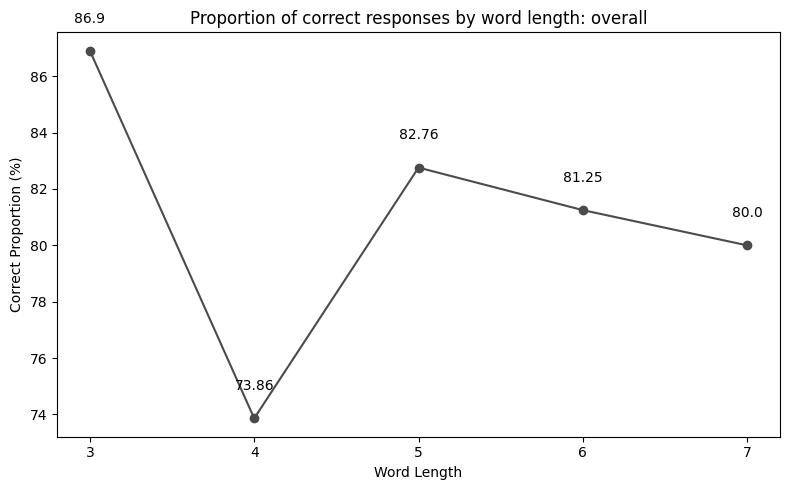

In [264]:
III_plot_correct_accuracy(imgordall,f"./figure/{username} III percent by len all.png", "Proportion of correct responses by word length: overall")

# plot accuracy response for each word length in thai and english language
 plot correct and wrong accuracy both thai and english as percentage from `score` by the column `len`

In [265]:
def III_plot_grouped_proportion(df1, df2, dir, title="Comparison of Correct Proportion by Word Length"):
    pdf1 = df1.groupby('len')['score'].mean() * 100
    pdf2 = df2.groupby('len')['score'].mean() * 100

    plt.figure(figsize=(6, 4))
    plt.plot(pdf1.index, pdf1.values, color = bluegradient[2], marker = 'o', label = "Thai")
    plt.plot(pdf2.index, pdf2.values, color = redgradient[2], marker = 'o', label = "English")

    # def addlabels(x,y):
    #     for i in range(len(x)):
    #         plt.text(i+3,y[i]+1,round(y[i], 2), horizontalalignment = 'center')

    # addlabels(pdf1.index, pdf1.values)
    # addlabels(pdf2.index, pdf2.values)
    plt.legend()

    plt.xticks(np.arange(3,8,1))
    plt.ylim(0,100)

    plt.xlabel("Word Length")
    plt.ylabel("Proportion of Correct Responses (%)")
    plt.title(title)
    plt.tight_layout()
    #plt.savefig(dir)



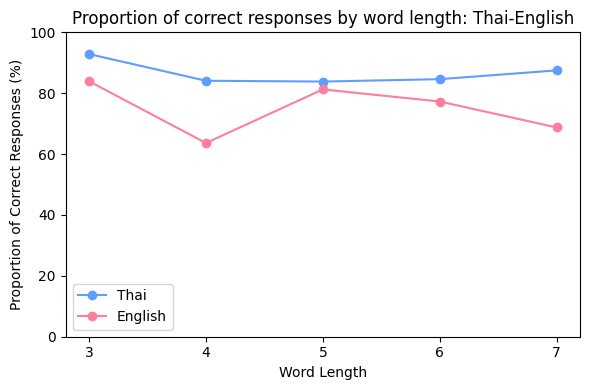

In [266]:
III_plot_grouped_proportion(imgordth,imgorden,f"./figure/{username} III percent by len TH-EN.png","Proportion of correct responses by word length: Thai-English")

In [267]:
def III_plot_grouped_stim(df, title="Comparison of Correct Proportion by Word Length"):
    pdf = df.groupby(['len', 'truestate'])['score'].mean().mul(100).unstack()
    print(pdf)

    plt.figure(figsize=(6, 4))
    plt.plot(pdf.index, pdf[1], color = colcorrect, marker = 'o', label = "matched")
    plt.plot(pdf.index, pdf[0], color = redgradient[4], marker = 'o', label = "mismatched")

    # def addlabels(x,y):
    #     for i in range(len(x)):
    #         plt.text(i+3,y[i]+1,round(y[i], 2), horizontalalignment = 'center')

    # addlabels(pdf1.index, pdf1.values)
    # addlabels(pdf2.index, pdf2.values)
    plt.legend()

    plt.xticks(np.arange(3,8,1))
    plt.ylim(0,100)

    plt.xlabel("Word Length")
    plt.ylabel("Proportion of Correct Responses (%)")
    plt.title(title)
    plt.tight_layout()
    #plt.savefig(dir)



truestate        0.0        1.0
len                            
3.0        95.238095  78.571429
4.0        84.090909  63.636364
5.0        89.655172  75.862069
6.0        85.416667  77.083333
7.0        92.500000  67.500000


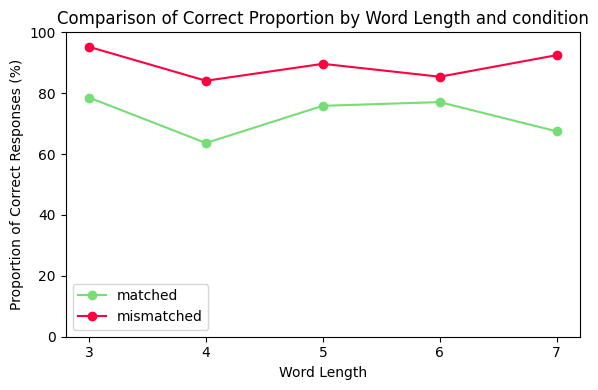

In [268]:
III_plot_grouped_stim(imgordall, title="Comparison of Correct Proportion by Word Length and condition")

# plot image and word accuracy
plot both accuracy of the task order that word shown match the image and word shown is not matched with the image

In [269]:
def III_plot_image_accuracy(df, title="Image Accuracy", save_path=None):

    # Calculate correct image accuracy
    correct_total = df[df['truestate'] == 1].shape[0]
    correct_match = df[(df['truestate'] == 1) & (df['key'] == 'z')].shape[0]
    correct_accuracy = (correct_match / correct_total) * 100 if correct_total else 0

    # Calculate incorrect image accuracy
    incorrect_total = df[df['truestate'] == 0].shape[0]
    incorrect_match = df[(df['truestate'] == 0) & (df['key'] == 'x')].shape[0]
    incorrect_accuracy = (incorrect_match / incorrect_total) * 100 if incorrect_total else 0

    print(f"{correct_match}/{correct_total} = {correct_accuracy}, {incorrect_match}/{incorrect_total} = {incorrect_accuracy}")
    # Bar chart data
    categories = ['Image word matched', 'Image word mismatched']
    values = [correct_accuracy, incorrect_accuracy]

    # Plot
    plt.figure(figsize=(4,4))
    plt.plot(categories, values, color=colcorrect, marker = 'o')
    plt.ylabel('Accuracy (%)')
    plt.title(title)
    plt.ylim(0,100)

    # # Add percentage labels on top of bars
    # for bar, value in zip(bars, values):
    #     plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, f'{value:.1f}%', 
    #              ha='center', fontsize=10, fontweight='light')



169/232 = 72.84482758620689, 207/232 = 89.22413793103449


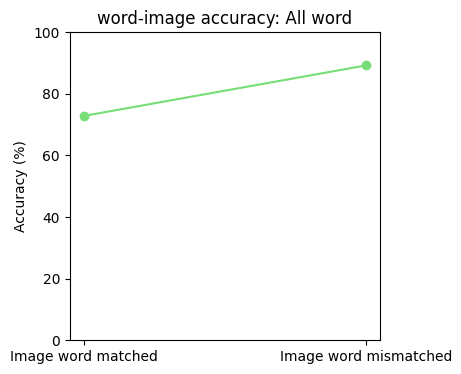

In [270]:
III_plot_image_accuracy(imgordall, "word-image accuracy: All word", f"./figure/{username} III image truefalse All.png")

#  grouped bar chart with the correct and incorrect image accuracy, both language

In [271]:
def III_accuracy_group(df1, df2, title="Image Accuracy", save_path=None):

    def acc(df, k_true='z', k_false='x'):
        t1 = df['truestate'] == 1
        t0 = df['truestate'] == 0
        a1 = (df[t1]['key'] == k_true).mean() * 100 if t1.any() else 0
        a0 = (df[t0]['key'] == k_false).mean() * 100 if t0.any() else 0
        return a1, a0
    
    a1, a0 = acc(df1)
    b1, b0 = acc(df2)

    th_value = [a1, a0]
    en_value = [b1, b0]


    categories = ['Image-word matched', 'Image-word mismatched']
    # # Plot
    # width = 0.35  # Width of bars
    # fig, ax = plt.subplots(figsize=(8, 6))

    # # Grouped bar plot
    # ax.bar([x - width/2 for x in range(len(categories))], values_1, width, label='Thai', color=bluegradient[4], edgecolor = 'black')
    # ax.bar([x + width/2 for x in range(len(categories))], values_2, width, label='English', color=redgradient[4], edgecolor = 'black')

    plt.figure(figsize=(4,4))
    plt.plot(categories, th_value, label = "Thai", color = thaicolor, marker= 'o')
    plt.plot(categories, en_value, label = "English", color = engcolor, marker = 'o')
    # Labels, title, and axis limits
    plt.ylabel('Accuracy (%)')
    plt.title(title)
    plt.xticks(range(len(categories)))
    plt.ylim(0,100)
    
    # Add percentage labels on top of bars
    # for i, (value_1, value_2) in enumerate(zip(values_1, values_2)):
    #     ax.text(i - width/2, value_1 + 2, f'{value_1:.1f}%', ha='center', fontsize=10, fontweight='light')
    #     ax.text(i + width/2, value_2 + 2, f'{value_2:.1f}%', ha='center', fontsize=10, fontweight='light')

    # Add legend
    plt.legend()

    # # Save or show plot
    # if save_path:
    #     plt.savefig(save_path, bbox_inches='tight', dpi=300)
    #     print(f"Plot saved to {save_path}")
    # else:
    #     plt.show()

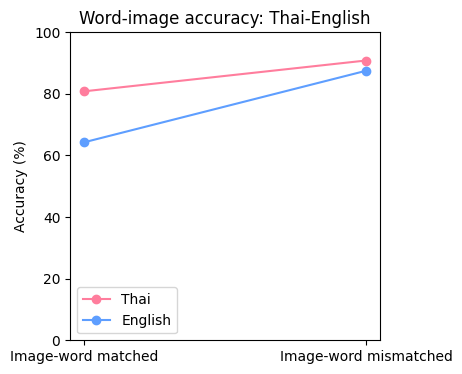

In [272]:
III_accuracy_group(imgordth, imgorden, "Word-image accuracy: Thai-English",f"./figure/{username} III image truefalse TH-EN.png")

# Reaction time part
---

In [275]:
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
#  remove outlier
rtimgordall = III_remove_excluded_words(imgordall, ['pigeon'])
rtimgorden = III_remove_excluded_words(imgorden, ['pigeon'])

rtimgordall = rtimgordall[rtimgordall['score'] == 1]
rtimgorden = rtimgorden[rtimgorden['score'] == 1]
rtimgordth = imgordth[imgordth['score'] == 1]

Rows removed: 4
Rows removed: 4


## Overall reaction time in both histogram and boxplot

In [276]:
import matplotlib.font_manager as fm
import math
thai_font_path="./THSarabun.ttf"
def III_plot_RT_outliers(inidf, lang, ylim, title="Reaction Time Choosing Image Appear", save_path=None):


    df = inidf[inidf['score'] == 1]
    if 'key_RT' not in df or 'word shown' not in df:
        raise ValueError("The DataFrame must contain 'key_RT' and 'word shown' columns.")

    # Calculate outlier thresholds using IQR method
    Q1 = df['key_RT'].quantile(0.25)
    Q3 = df['key_RT'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Find outliers
    outliers = df[(df['key_RT'] < lower_bound) | (df['key_RT'] > upper_bound)]
    outliers.sort_values(by=['key_RT'], inplace = True)


    # Create the plot
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 6), gridspec_kw={'height_ratios': [1, 3]})

    #create y limit for global
    x_lim = math.ceil(max(df['key_RT']))
    print(x_lim)
    # Boxplot (Top)
    sns.boxplot(data=df, x='key_RT', ax=axes[0], color='lightgray')
    axes[0].set_title(title)
    axes[0].set_xlabel('')
    axes[0].set_xticks(np.arange(0,x_lim+1,1))
    axes[0].set_xlim(0,x_lim)
    # axes[0].set_xticks(np.arange(0,16,1))
    # Annotate outliers with the corresponding 'word shown' using the Thai font if provided
    prop = fm.FontProperties(fname=thai_font_path)
    i = 0
    for outlier_value, word in zip(outliers['key_RT'], outliers['word shown']):
        yax = 0 + 0.25 * ((-1) ** i)
        axes[0].text(outlier_value, yax, word, fontsize=10, ha='center', va = 'center',color='black', fontweight='light', rotation=90, fontproperties=prop)
        i = i + 1
# 
    # axes[0].set_yticks([])  # Hide y-axis ticks
    # axes[0].set_xlabel("")  # Remove x-axis label

    # Histogram (Bottom)
    colorchoice = thaicolor if lang == 'th' else engcolor if lang == 'en' else gaygradient[4] 
    axes[1].hist(df['key_RT'], bins=range(0, x_lim + 1, 1),color=colorchoice, alpha=0.7, edgecolor='black')
    axes[1].set_title('')
    axes[1].set_xlabel("Reaction Time (s)")
    axes[1].set_xticks(np.arange(0,x_lim+1,1))
    axes[1].set_xlim(0,x_lim)
    axes[1].set_ylabel("Frequency")
    # axes[1].set_xticks(np.arange(0,20,1))
    # axes[1].set_xlim(0,15)
    # axes[1].set_ylim(0,ylim)

    # # Save the plot if save_path is provided
    # if save_path:
    #     plt.savefig(save_path, bbox_inches='tight', dpi=300)
    #     print(f"Plot saved to {save_path}")

    # plt.close()  # Prevent displaying the plot



C:\Users\UserPC\AppData\Local\Temp\ipykernel_25640\3660118144.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outliers.sort_values(by=['key_RT'], inplace = True)
C:\Users\UserPC\AppData\Local\Temp\ipykernel_25640\3660118144.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outliers.sort_values(by=['key_RT'], inplace = True)
C:\Users\UserPC\AppData\Local\Temp\ipykernel_25640\3660118144.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

13
15
15


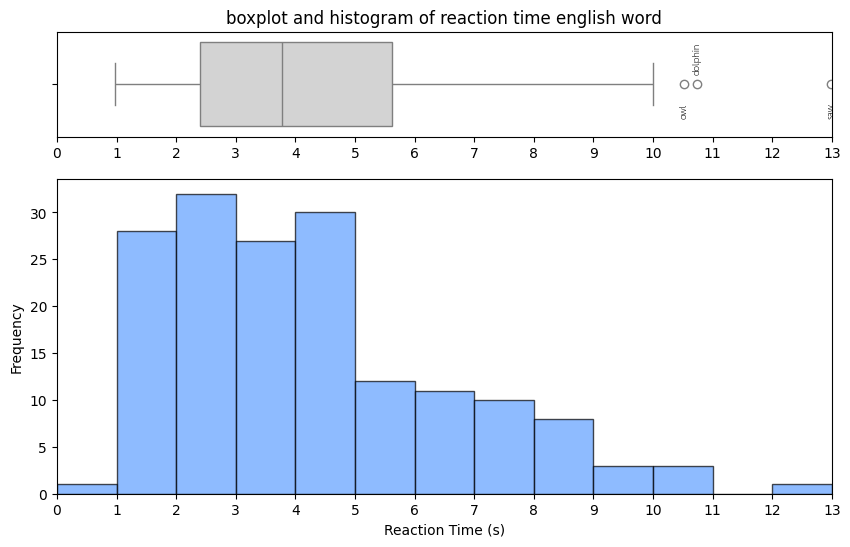

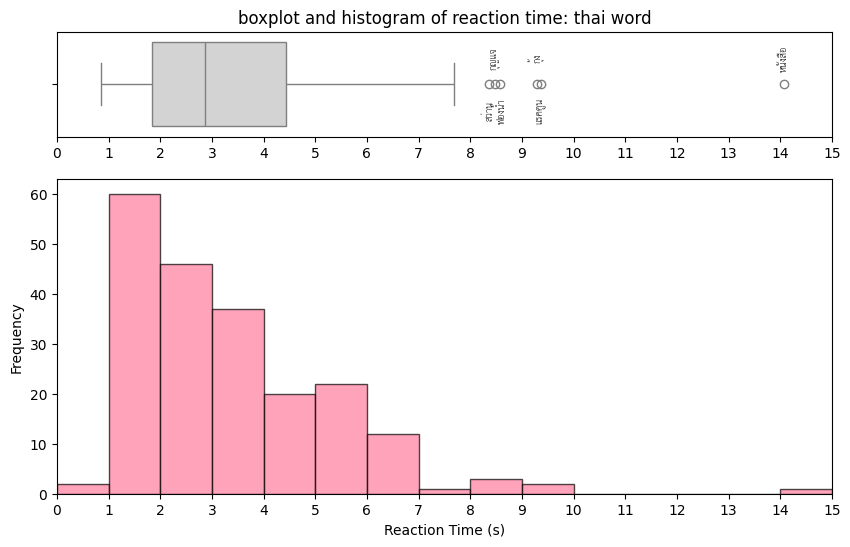

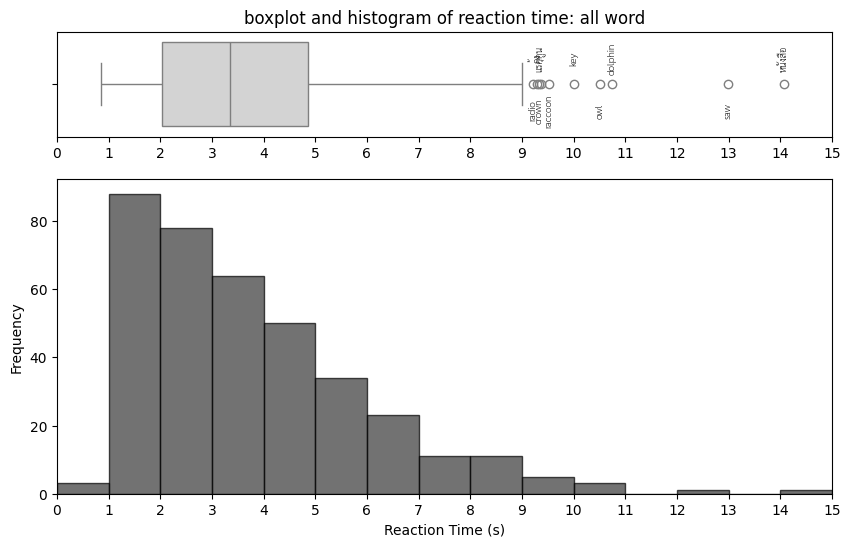

In [277]:
III_plot_RT_outliers(rtimgorden, 'en', 65,"boxplot and histogram of reaction time english word", f"./figure/{username} III RT hist english.png" )
III_plot_RT_outliers(rtimgordth,'th' ,65,"boxplot and histogram of reaction time: thai word", f"./figure/{username} III RT hist thai.png")
III_plot_RT_outliers(rtimgordall, 'all',100,"boxplot and histogram of reaction time: all word", f"./figure/{username} III RT hist all.png")


# Reaction time by word image match state
plot a bar chart between reaction time (s) mean by the truestate of the task

In [162]:
def III_plot_RTgroup_by_state(df1, df2, title, save_dir):
  # Add a 'source' column to each dataframe to differentiate the datasets
  # Add 'source' column to differentiate datasets
  df1['source'] = 'Thai'
  df2['source'] = 'English'
  combined_df = pd.concat([df1, df2])

  combined_df['source'] = pd.Categorical(combined_df['source'], categories=['Thai', 'English'], ordered=True)
  combined_df['truestate'] = pd.Categorical(combined_df['truestate'], categories=[1, 0], ordered=True)

  # Calculate means and errors
  means = combined_df.groupby(['source', 'truestate'], observed=False)['key_RT'].mean().unstack(level=0)
  errors = combined_df.groupby(['source', 'truestate'],observed=False)['key_RT'].sem().unstack(level=0)

  # Define colors for each dataset

  categories = ['Image-word matched', 'Image-word mismatched']
  print(means, errors)
  plt.figure(figsize = (4,4))
  plt.errorbar(categories, means['Thai'], yerr= errors['Thai'],capsize = 3,label = 'Thai', color = thaicolor, marker = 'o')
  plt.errorbar(categories, means['English'],yerr= errors['English'],capsize = 3,label = 'English', color = engcolor, marker = 'o')
  # for i, language in enumerate(means.columns):
  #     offset = width * i
  #     colorchoice = colors[language]
  #     barcon = ax.bar(x + offset, means[language], width, label=language, yerr=errors[language], color=colorchoice, capsize=5, edgecolor="black")

      # rounded_labels = [f'{val:.2f}' for val in means[language]]
      # ax.bar_label(barcon, labels=rounded_labels,padding=3)

  # Add labels, title, and customize the x-axis ticks
  plt.ylabel('Reaction Time (s)')
  plt.xlabel('match state')
  plt.title(title)
  plt.legend()
  plt.ylim(0, 6)

  # plt.savefig(save_dir)


source         Thai   English
truestate                    
1          2.965970  4.408972
0          3.678668  4.166981 source         Thai   English
truestate                    
1          0.177123  0.326112
0          0.198560  0.215361


C:\Users\UserPC\AppData\Local\Temp\ipykernel_25640\2965762623.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['source'] = 'Thai'


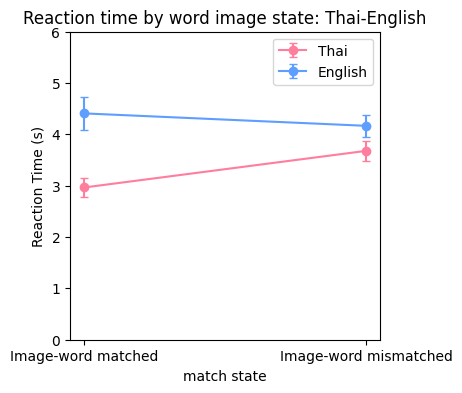

In [278]:
III_plot_RTgroup_by_state(rtimgordth, rtimgorden, "Reaction time by word image state: Thai-English", f"./figure/{username} III RT by state EN-TH.png")

# Reaction time by word image match state both language
plot a grouped bar chart between reaction time (s) mean by the truestate of the task, both thai and english next to each other

In [160]:
def III_plot_RT_with_error_bars(df, title, save_dir):

    # Calculate means and errors by grouping by 'truestate'
    df['truestate'] = pd.Categorical(df['truestate'], categories=[1, 0], ordered=True)
    means = df.groupby('truestate', observed=False)['key_RT'].mean()
    print(means)
    errors = df.groupby('truestate', observed=False)['key_RT'].sem()
    categories = ['Image-word matched', 'Image-word mismatched']
    # Set the figure size (adjust accordingly)
    plt.figure(figsize=(4,4))  # Change the width and height here
    
    plt.errorbar(categories, means, yerr = errors, capsize = 3, color = colcorrect, marker = 'o')
    
    # Set bar width to scale with figure size
    # bar_width = 0.4  # Adjust the bar width to fit within the plot's space
    # x = np.arange(len(means.index))
    # # Bar plot with error bars
    # bars = plt.bar(x, means, yerr=errors, capsize=5, width=bar_width, color=[colcorrect, colincorrect], edgecolor = 'black')

    # # Add the mean label on top of the bars
    # for i, bar in enumerate(bars):
    #     height = bar.get_height()
    #     error = errors.iloc[i]  # Get the error for this specific bar
    #     plt.text(bar.get_x() + bar.get_width() / 2, height + error + 0.05, f'{height:.2f}', ha='center', va='bottom', fontsize=12)

    # # Set custom x-ticks and labels
    # plt.xticks(x, means.index.map({0: 'Image word mismatched', 1: 'Image word matched'}))

    # Labels and title
    plt.xlabel('match state')
    plt.ylabel('Reaction Time (s)')
    plt.title(title)
    plt.ylim(0,6)

    # Save the plot to the specified directory
    # plt.tight_layout()
    # plt.savefig(save_dir)
 



truestate
1    3.570821
0    3.907341
Name: key_RT, dtype: float64


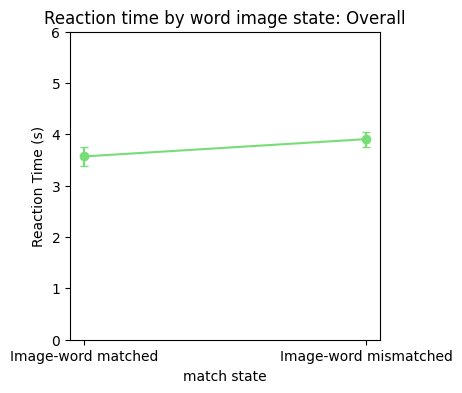

In [279]:
III_plot_RT_with_error_bars(rtimgordall, "Reaction time by word image state: Overall", f"./figure/{username} III RT by state all.png")

# Reaction time byword length
plot a bar chart between reaction time (s) mean by the word length

In [29]:
def III_plot_rt_by_len(dataframe, titles, save_path):
    # Calculate means and standard errors
    means = dataframe.groupby('len')['key_RT'].mean()
    stderr = dataframe.groupby('len')['key_RT'].sem()
    
    word_lengths = np.arange(3, 8)
    
    plt.figure(figsize=(8, 5))
    plt.errorbar(word_lengths, means, yerr=stderr, capsize=2, color=gaygradient[2], fmt = 'o-')
    
    plt.title(titles, fontsize=14)
    plt.xlabel('Word Length (letters)', fontsize=12)
    plt.ylabel('Mean Response Time (seconds)', fontsize=12)
    plt.xticks(word_lengths)
    plt.ylim(0,7)
    
    def addlabels(x,y):
        for i in word_lengths:
            plt.text(i,y[i]+stderr[i]+0.1,round(y[i], 2), horizontalalignment = 'center')

    addlabels(word_lengths, means)
    # Save the plot
    plt.tight_layout()


    plt.savefig(save_path)
    print(f"Plot saved at: {save_path}")

Plot saved at: ./figure/PN III RT by len all.png


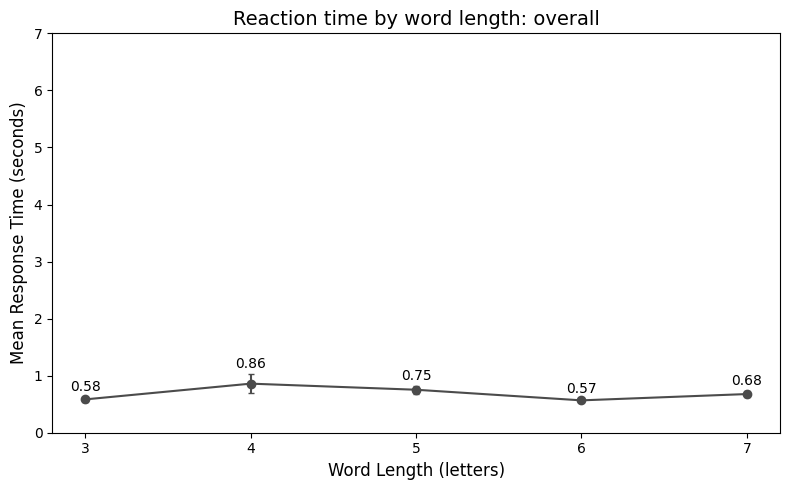

In [30]:
III_plot_rt_by_len(imgordall, "Reaction time by word length: overall", f"./figure/{username} III RT by len all.png") 

# Reaction time by word length, both language
plot a bar chart between reaction time (s) mean by the truestate of the task

In [158]:
def III_plot_rt_by_len_group(df1, df2, title, save_dir):
    # Calculate means and standard errors for both dataframes
    means1 = df1.groupby('len')['key_RT'].mean()
    stderr1 = df1.groupby('len')['key_RT'].sem()

    means2 = df2.groupby('len')['key_RT'].mean()
    stderr2 = df2.groupby('len')['key_RT'].sem()

    # Word lengths from 3 to 7
    word_lengths = np.arange(3,8)

    # Set the figure size and bar width
    plt.figure(figsize=(6,4))  # Adjust the width and height here
    plt.errorbar(word_lengths, means1, yerr = stderr1, capsize = 2, fmt = 'o-', color = thaicolor, label = 'Thai')
    plt.errorbar(word_lengths, means2, yerr = stderr2, capsize = 2, fmt = 'o-', color = engcolor, label = "English")
    
    # def addlabels(x,y,err):
    #     for i in word_lengths:
    #         plt.text(i,y[i]+err[i]+0.1,round(y[i], 2), horizontalalignment = 'center')

    # addlabels(word_lengths, means1, stderr1)
    # addlabels(word_lengths, means2, stderr2)

    # Labels and title
    plt.xlabel('Word Length (letters)')
    plt.ylabel('Mean Response Time (seconds)')
    plt.title(title)
    plt.xticks(word_lengths)
    plt.ylim(0,7)
    plt.legend(loc = 'upper left')

    # Save the plot to the specified directory
    # plt.tight_layout()
    # plt.savefig(save_dir)

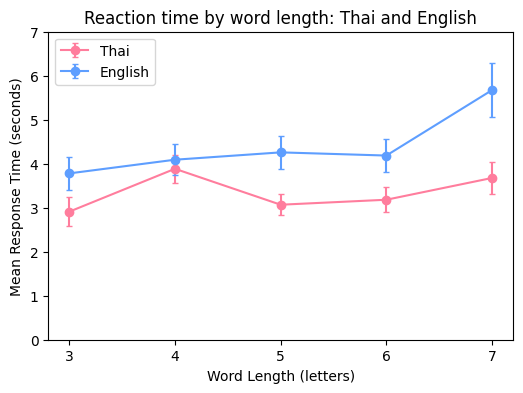

In [280]:

III_plot_rt_by_len_group(rtimgordth, rtimgorden, "Reaction time by word length: Thai and English", f"./figure/{username} III RT by len EN-TH.png")

In [156]:
def III_plot_rt_by_len_stim(df, title):
    # Calculate means and standard errors for both dataframes
    means1 = df.groupby(['len', 'truestate'])['key_RT'].mean().unstack()
    sems1 = df.groupby(['len', 'truestate'])['key_RT'].sem().unstack()
    print(means1)
    # Word lengths from 3 to 7
    plt.figure(figsize=(6,4))
    plt.errorbar(means1.index, means1[1],  yerr = sems1[1], label = 'matched', color = colcorrect, marker = 'o', capsize = 3)
    plt.errorbar(means1.index, means1[0],  yerr = sems1[0], label = 'mismatched', color = redgradient[4], marker = 'o', capsize = 3)

    # def addlabels(x,y,err):
    #     for i in word_lengths:
    #         plt.text(i,y[i]+err[i]+0.1,round(y[i], 2), horizontalalignment = 'center')

    # addlabels(word_lengths, means1, stderr1)
    # addlabels(word_lengths, means2, stderr2)

    # Labels and title
    word_lengths = np.arange(3,8)
    plt.xlabel('Word Length (letters)')
    plt.ylabel('Mean Response Time (seconds)')
    plt.title(title)
    plt.ylim(0,7)
    plt.xticks(word_lengths)
    plt.legend(loc = 'upper left')

    # Save the plot to the specified directory
    # plt.tight_layout()
    # plt.savefig(save_dir)

truestate         1         0
len                          
3.0        3.481393  3.461274
4.0        3.435907  4.380693
5.0        3.476529  3.614977
6.0        3.388038  3.768429
7.0        4.210636  4.473536


C:\Users\UserPC\AppData\Local\Temp\ipykernel_25640\3137042538.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means1 = df.groupby(['len', 'truestate'])['key_RT'].mean().unstack()
C:\Users\UserPC\AppData\Local\Temp\ipykernel_25640\3137042538.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sems1 = df.groupby(['len', 'truestate'])['key_RT'].sem().unstack()


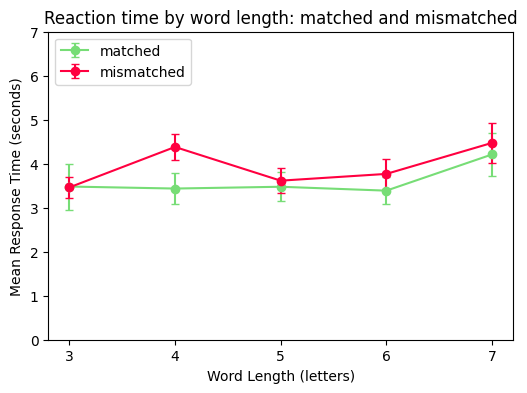

In [284]:
III_plot_rt_by_len_stim(rtimgordall, "Reaction time by word length: matched and mismatched")